# Concrete Strength - Machine Learning
This project has the goal of predicting the concrete strength based on some features.

## Data
The dataset was provided by Kaggle: https://www.kaggle.com/datasets/maajdl/yeh-concret-data
And ahs the following sctructure:

* `Cement`: kg in a m3 mixture
* `Blast Furnace Slag`: kg in a m3 mixture
* `Fly Ash`: kg in a m3 mixture
* `Water`: kg in a m3 mixture
* `Superplasticizer`: kg in a m3 mixture
* `Coarse Aggregate`: kg in a m3 mixture
* `Fine Aggregate`: kg in a m3 mixture
* `Age`: Day (1~365) 
* `Concrete compressive strength`: MPa (target)

## Importing tools

In [1]:
# utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# models(estimators)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR # kernl='linear' and kernel='rbf'
from sklearn.ensemble import RandomForestRegressor

# fitting tools
from sklearn.model_selection import train_test_split

# evaluation tools
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
# getting the data
df = pd.read_csv("data/concrete_data.csv")
df.sort_values(by=["csMPa"], ascending=False, inplace=True)

# top 5 strength
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
181,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
381,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
153,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
159,389.9,189.0,0.0,145.9,22.0,944.7,755.8,56,79.40


In [3]:
# bottom 5 strength
df.tail()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
717,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.83
668,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.78
652,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
705,122.6,183.9,0.0,203.5,0.0,958.2,800.1,3,3.32
688,108.3,162.4,0.0,203.5,0.0,938.2,849.0,3,2.33


In [4]:
len(df)

1030

In [5]:
# checking for missing values
df.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

In [6]:
# checking for duplicates
df.duplicated().sum()

25

In [7]:
# removing duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Correlation Matrix

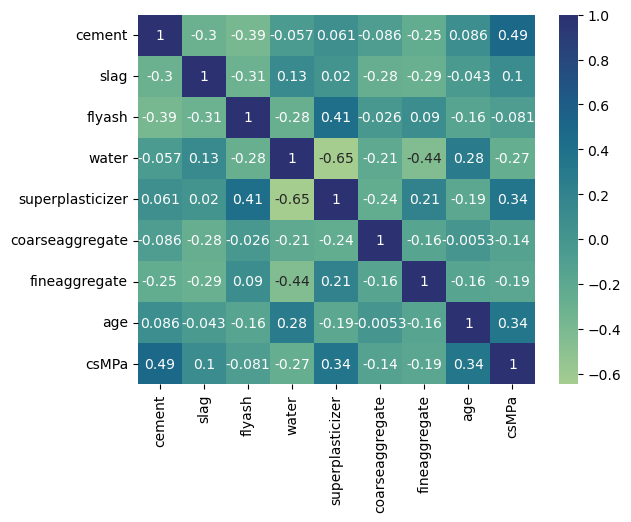

In [8]:
corr = df.corr()
sn.heatmap(corr, annot=True, cmap="crest")
plt.show()

### Ploting potential features

### Cement x Strength

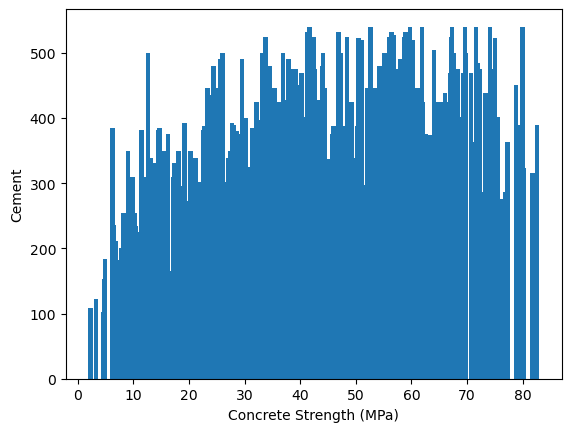

In [9]:
fig, ax = plt.subplots()
ax.bar(df.csMPa, df.cement)
ax.set(xlabel="Concrete Strength (MPa)", ylabel="Cement")
plt.show()

It is kinda visible a slight curve ascending. 

### Superplasticize x Strength

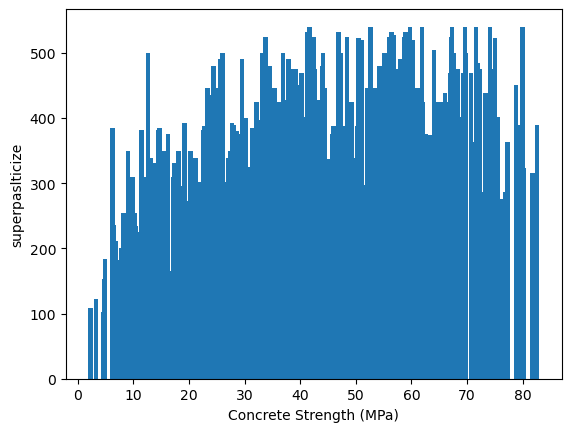

In [10]:
fig, ax = plt.subplots()
ax.bar(df.csMPa, df.cement)
ax.set(xlabel="Concrete Strength (MPa)", ylabel="superpaslticize")
plt.show()

Again kinda a ascending curve

## Modeling

In [11]:
# making results predictable
np.random.seed(55)

# models dict
models = {
    "linear_svr": SVR(kernel="linear"),
    "rbf_svr": SVR(kernel="rbf"),
    "ridge": Ridge(),
    "random_forest": RandomForestRegressor()
}

### Splitting the data

In [12]:
# separating features from labels
x = df.drop("csMPa", axis=1)
y = df.csMPa

In [13]:
# separating train from test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [14]:
results = {}

# training with the models
for name, model in models.items():
    model.fit(x_train, y_train)
    results[name] = model.score(x_test, y_test)

# showing the results
results

{'linear_svr': 0.4758738051799126,
 'rbf_svr': 0.19217094499073573,
 'ridge': 0.5476532001571244,
 'random_forest': 0.8911765957709138}

The evaluation metric is R squared and show that the RandomForest is the well fitted model

In [15]:
# checking for MAE metric (the lower the better)
results = {}

# training with the models
for name, model in models.items():
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    results[name] = mean_absolute_error(y_test, y_preds)

# showing the results
results

{'linear_svr': 8.172608017273898,
 'rbf_svr': 10.878110910192806,
 'ridge': 8.155974880513027,
 'random_forest': 3.4604146162046905}

Again, the best model is the RandomForestRegressor. It will be used for the final model

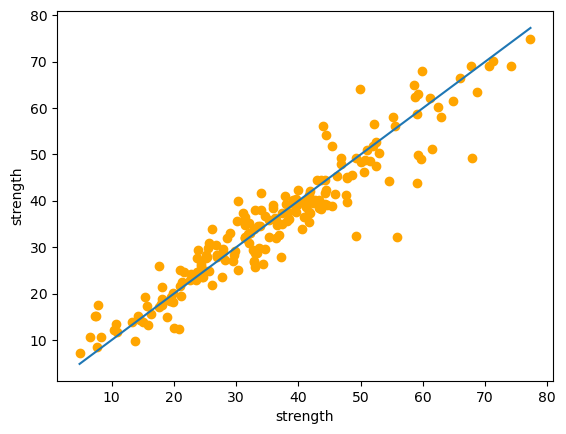

In [17]:
# seeing the random forest predictions
y_preds = models["random_forest"].predict(x_test)

# plotting the difference
fig, ax = plt.subplots()

ax.scatter(y_test, y_preds, c="orange")
ax.plot((np.min(y_test), np.max(y_test)), (np.min(y_test), np.max(y_test)))
ax.set(xlabel="strength", ylabel="strength")


plt.show()

This plot shows how good the model is predicting. The more closest the dots are on the line, the more well the model is predicting.

### Tuning hyperparams

In [78]:
# building hyperparms grid
random_forest_grid = {
    "n_estimators": np.arange(100, 150, 10),
    "max_depth": [None, 2, 8, 16, 20, 24, 32],
    "criterion": ["absolute_error"],
    "min_samples_split": [2, 4, 6, 8]
}

In [79]:
# making predictable
np.random.seed(55)

# tuning
rf_gs = GridSearchCV(RandomForestRegressor(),
                    param_grid=random_forest_grid,
                    cv=4,
                    n_jobs=-1)

# fitting all combinations
rf_gs.fit(x_train, y_train)

# scoring best model
rf_gs.score(x_test, y_test)

0.8993949025116941

Improvement: 0.8911 -> 0.8993

In [80]:
rf_gs.best_params_

{'criterion': 'absolute_error',
 'max_depth': 24,
 'min_samples_split': 2,
 'n_estimators': 140}

In [81]:
# training the model
np.random.seed(42)

model = RandomForestRegressor(criterion='absolute_error', max_depth=24, n_estimators=110, min_samples_split=2)

# training the model
model.fit(x_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=24,
                      n_estimators=110)

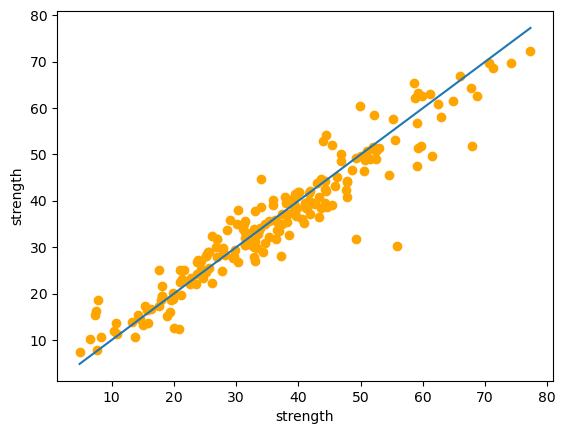

In [38]:
# making predicitons
y_preds = model.predict(x_test)

# plotting the difference
fig, ax = plt.subplots()

ax.scatter(y_test, y_preds, c="orange")
ax.plot((np.min(y_test), np.max(y_test)), (np.min(y_test), np.max(y_test)))
ax.set(xlabel="strength", ylabel="strength")


plt.show()

## Results

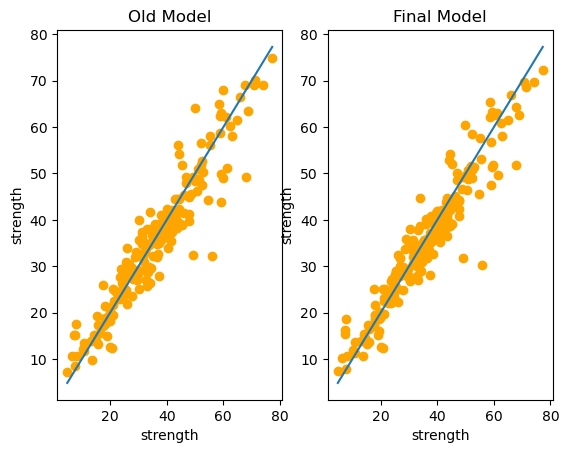

In [43]:
old_model = models["random_forest"]
final_model = model

# old preds
old_preds = old_model.predict(x_test)
final_preds = final_model.predict(x_test)

# plotting comparison
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)

ax1.scatter(y_test, old_preds, c="orange")
ax1.plot((np.min(y_test), np.max(y_test)), (np.min(y_test), np.max(y_test)))
ax1.set(xlabel="strength", ylabel="strength")
ax1.set_title("Old Model")

ax2.scatter(y_test, final_preds, c="orange")
ax2.plot((np.min(y_test), np.max(y_test)), (np.min(y_test), np.max(y_test)))
ax2.set(xlabel="strength", ylabel="strength")
ax2.set_title("Final Model")

plt.show()

### Plotting the diferences

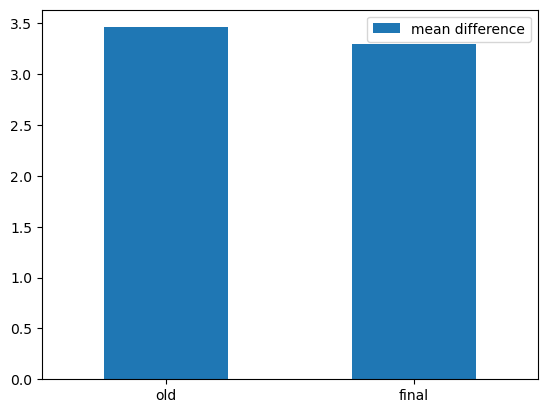

In [72]:
old_diffs_mean = np.absolute(old_preds - y_test).mean()
final_diffs_mean = np.absolute(final_preds - y_test).mean()

mean_df = pd.DataFrame(data=[old_diffs_mean, final_diffs_mean], index=["old", "final"], columns=["mean difference"])
mean_df.plot.bar()
plt.xticks(rotation=False)

plt.show()

It shows that the final model predictions are closer to the reality relatively to the old model 